Might do this concurrently in PyTorch and Keras

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import fmin_l_bfgs_b
import scipy

from keras.models import Model
from keras import metrics
from keras import backend as K

from vgg16_avg import VGG16_Avg as vgg

%matplotlib inline

Using TensorFlow backend.


In [2]:
path = '../data/train/'

In [3]:
fnames = glob.glob(path+'**/*.JPEG', recursive=True)
n = len(fnames); n

19439

In [4]:
fn = fnames[2090]; fn

'../data/train/n02102318/n02102318_10231.JPEG'

In [5]:
fn = '../data/train/n01558993/n01558993_9684.JPEG'

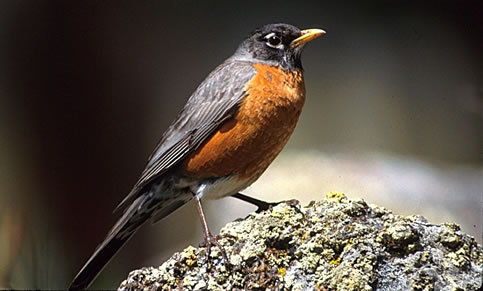

In [6]:
img=Image.open(fn); img

Need to subtract the VGG mean to make it work w/ VGG

In [7]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255).astype(np.uint8)

Also reshape to add the "batch_size"

In [8]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

Here we get a pretrained net (VGG but with max pooling replaced with avg pooling to retain information)

In [9]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)

In [10]:
class Evaluator(object):
    def __init__(self, f, shape): self.f, self.shp = f, shape
        
    def loss(self, x):
        loss_, self.grads_ = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    
    def grads(self, x):
        return self.grads_.flatten().astype(np.float64)

In [11]:
def solve_image(eval_obj, img, niter):
    for _ in range(niter):
        img, min_val, info = fmin_l_bfgs_b(eval_obj.loss, img.flatten(),
                                        fprime=eval_obj.grads, maxfun=40)
        img = np.clip(img, -127, 127)
        print('Current loss value:', min_val)
    return img

First need to set up the image part - aka, put it through ~5 layers of VGG

In [12]:
model = vgg(include_top=False)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

Choose the first conv on the fifth layer (can check out different ones, but this is the one they use)

In [14]:
layer = model.get_layer('block5_conv1').output

In [15]:
partial_model = Model(model.input, layer)

In [16]:
targ = partial_model.predict(img_arr)

In [17]:
targ.shape

(1, 18, 30, 512)

In [18]:
metrics.mse(layer, targ)

<tf.Tensor 'Mean:0' shape=(?, 18, 30) dtype=float32>

In [19]:
img_arr.shape

(1, 291, 483, 3)

In the most recent Keras, the MSE only takes the mean along the last axis (I guess because it's thinking about batches, or something). Here we want it over all the input pixels so I'm just writing it here

In [20]:
def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

In [21]:
loss = mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

In [22]:
y = solve_image(evaluator, x, 10)

Current loss value: 18.7560901642
Current loss value: 7.51299524307
Current loss value: 4.75234699249
Current loss value: 3.60329890251
Current loss value: 2.99820184708
Current loss value: 2.5989921093
Current loss value: 2.43160629272
Current loss value: 2.43002486229
Current loss value: 2.40752840042
Current loss value: 2.40761899948


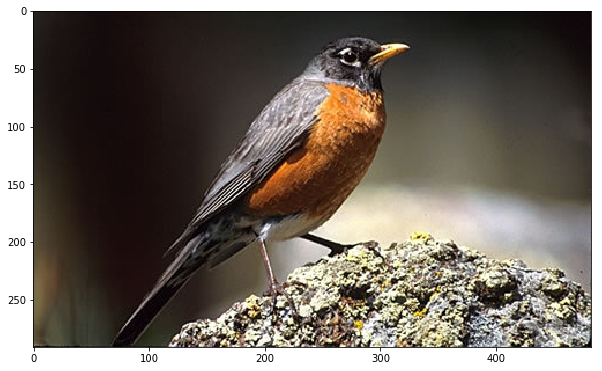

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(deproc(img_arr.copy(), shp)[0])

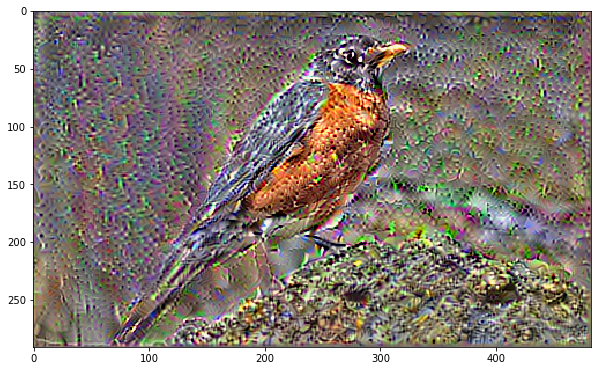

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(deproc(y.copy(), shp)[0])

OK! Now for the style part. Same thing, but with a given style. Gonna use this picasso image that I got off Google

In [31]:
pointy_fp = '../data/pointillism.jpg'

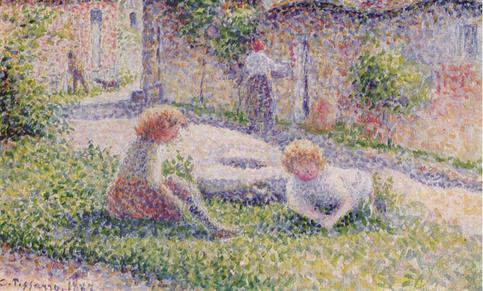

In [42]:
style_img = Image.open(pointy_fp) ; style_img

In [43]:
style_arr = preproc(np.expand_dims(style_img,0)[:,:,:,:3])
style_shp = style_arr.shape

In [45]:
model = vgg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

We're gonna use several layers here. We could have also done this for the style bits too.

In [46]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [47]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

We use the gramian matrix. No one really knows why it works, other than because it works out how much the features correlate and therefore throws away all location data whilst keeping 'texture' data

In [48]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [49]:
def style_loss(x, targ): return mse(gram_matrix(x), gram_matrix(targ))

In [50]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

In [51]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)

In [52]:
y = solve_image(evaluator, x, 10)

Current loss value: 27.4226646423
Current loss value: 1.7312797308
Current loss value: 0.430722802877
Current loss value: 0.402741253376
Current loss value: 0.332738906145
Current loss value: 0.331237435341
Current loss value: 0.331236720085
Current loss value: 0.331236749887
Current loss value: 0.33123677969
Current loss value: 0.331236720085


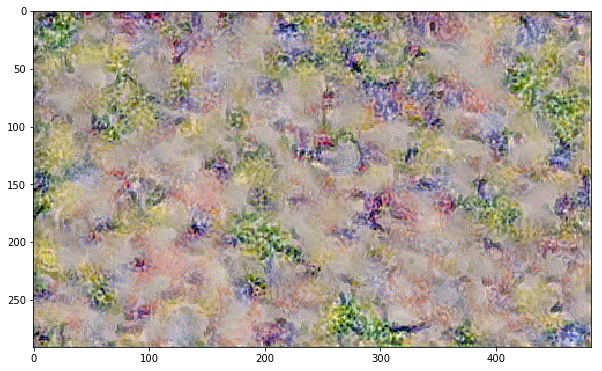

In [53]:
plt.figure(figsize=(10,10))
plt.imshow(deproc(y.copy(), shp)[0])

Putting it together!

In [54]:
model = vgg(include_top=False, input_shape=shp[1:])
outputs = {l.name:l.output for l in model.layers}

In [55]:
content_layer = model.get_layer('block4_conv2').output
style_layers = [outputs['block{}_conv1'.format(o)] for o in range(1,6)]
content_model = Model(model.input, content_layer)
style_model = Model(model.input, style_layers)

In [56]:
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]
content_targ = K.variable(content_model.predict(img_arr))

Content loss we're dividing by 10 to let the style have more of a look in.

TO WRITE: the weights, number of style layers, content loss weighting are important. Figure out how important!

In [57]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [58]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2, w in zip(style_layers, style_targs, style_wgts))
loss += mse(content_layer, content_targ)/15
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [59]:
evaluator = Evaluator(transfer_fn, shp)

In [60]:
x = rand_img(shp)

In [61]:
y = solve_image(evaluator, x, 10)

Current loss value: 136.007827759
Current loss value: 74.4414825439
Current loss value: 62.804889679
Current loss value: 58.6322975159
Current loss value: 56.6166877747
Current loss value: 54.9554367065
Current loss value: 53.7264709473
Current loss value: 52.5629501343
Current loss value: 51.6012077332
Current loss value: 50.8266830444


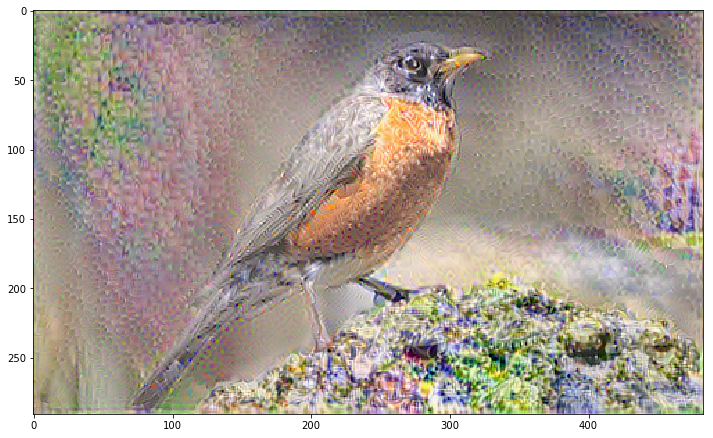

In [62]:
plt.figure(figsize=(12,12))
plt.imshow(deproc(y.copy(), shp)[0])